In [ ]:
import pandas as pd
import numpy as np
import torch    
import matplotlib.pyplot as plt

In [2]:
Path_To_DataFile = '/home/fedor-tairli/work/CDEs/PulseTriggering/Data/18.0_18.5/helium/EPOSLHC_R_180_185_helium_HybridSd_CORSIKA78010_FLUKA_Run010_traces.csv'
Data = pd.read_csv(Path_To_DataFile, header=None)

In [4]:
MetaData = Data.iloc[:, 0:3]
Traces = Data.iloc[:, 3:].values

In [6]:
MetaData = torch.tensor(MetaData.values, dtype=torch.int64)

In [ ]:
Traces = torch.tensor(Traces, dtype=torch.float32)

In [19]:
Traces[:,:1000].shape

torch.Size([2000, 1000])

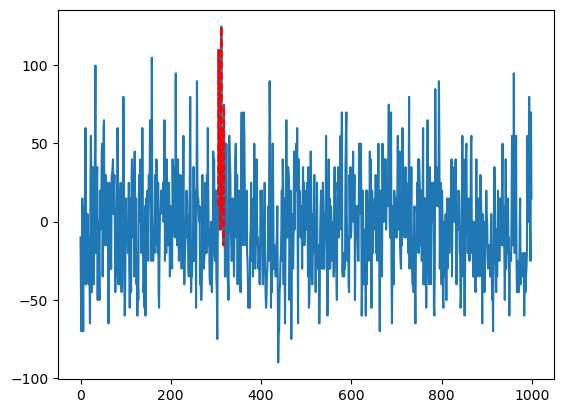

In [150]:
N = np.random.randint(0, Traces.shape[0])
TraceStart = MetaData[N, 1]
TraceEnd = MetaData[N, 2]


# plt.plot(Traces[N,TraceStart-20:TraceEnd+20].numpy())
plt.plot(Traces[N,:].numpy())
plt.plot(range(TraceStart,TraceEnd),Traces[N,TraceStart:TraceEnd].numpy(), 'r--')

(array([207., 380., 413., 334., 243., 212.,  81.,  47.,  36.,  16.,  13.,
          8.,   0.,   4.,   1.,   1.,   0.,   0.,   2.,   2.]),
 array([ 6. ,  8.2, 10.4, 12.6, 14.8, 17. , 19.2, 21.4, 23.6, 25.8, 28. ,
        30.2, 32.4, 34.6, 36.8, 39. , 41.2, 43.4, 45.6, 47.8, 50. ]),
 <BarContainer object of 20 artists>)

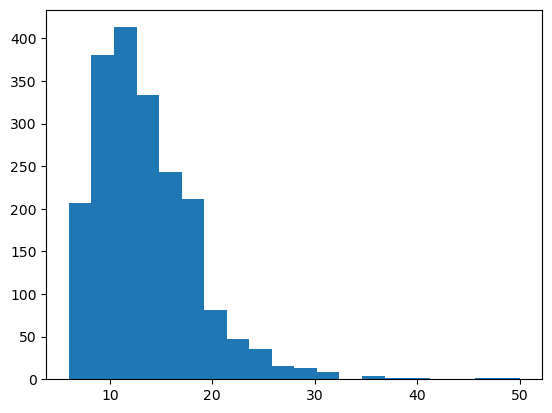

In [90]:
plt.hist(MetaData[:, 2].numpy()- MetaData[:, 1].numpy(), bins=20)